In [16]:
import os
import nibabel as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import re

import seaborn as sns
from adjustText import adjust_text
import matplotlib.colors as mcolors


os.chdir('projects\\common_cross_species_atlas')
#print("Current working directory:", os.getcwd())


# Figure 4

In [2]:
_dir='data/roistats/'
species=['mouse', 'marmoset', 'rhesus', 'human']
metric='volume (mm^3)'
exclude_rois=['OLF_Claustrum', 'BG_Substantia_Nigra', 'THL_Subthalamus', 'CBL', 'BST']
dfs=[]

for sp in species:
    df1=pd.read_table(_dir+'L2_332_moused_'+sp+'_roistats.txt', index_col=0).T[[metric]]
    df1.drop(exclude_rois, axis=0, inplace=True)
    #df2=pd.read_table(_dir+sp+'_cran_stats.txt', index_col=0).T[[metric]]
    df1[sp]=df1[metric]
    print(df1[metric].sum())
    df1.drop(metric, axis=1, inplace=True)
    
    dfs.append(df1)
    
    
df_cons=dfs[0].join(dfs[1]).join(dfs[2]).join(dfs[3])

df=df_cons
volume_data=df

# Group definitions
region_groups = {
    'Frontal': ["FRO_Precentral", "FRO_Premotor", "FRO_Prefrontal"],
    'Parietal': ["PAR"],
    'Temporal': ["TEM_Superior", "TEM_Inferior", "TEM_Medial", "TEM_Hippocampus", "TEM_Amygdala"],
    'Occipital': ["OCC_Lateral", "OCC_Medial"],
    'Insula': ["INS_Anterior", "INS_Posterior"],
    'Olfactory': ["OLF_Anterior", "OLF_Piriform"],
    'Cingulate': ["CIN_Anterior", "CIN_Posterior"],
    'Basal Ganglia': ["BG_CaudoPutamen", "BG_Accumbens", "BG_Pallidum"],
    'Thalamus': ["THL_Thalamus", "THL_Hypothalamus"]
}

# OPTIONAL split
# Surface/Deep sets (for ordering within each group)
surface_regions = {
    "FRO_Precentral","FRO_Premotor","FRO_Prefrontal","PAR",
    "TEM_Superior","TEM_Inferior","TEM_Medial",
    "OCC_Lateral","OCC_Medial","INS_Anterior","INS_Posterior",
    "CIN_Anterior","CIN_Posterior"
}
deep_regions = {
    "TEM_Hippocampus","TEM_Amygdala","OLF_Anterior","OLF_Piriform",
    "BG_CaudoPutamen","BG_Accumbens","BG_Pallidum",
    "THL_Thalamus","THL_Hypothalamus"
}


268.95300000000003
3470.216
50558.0583
759128.8200000001


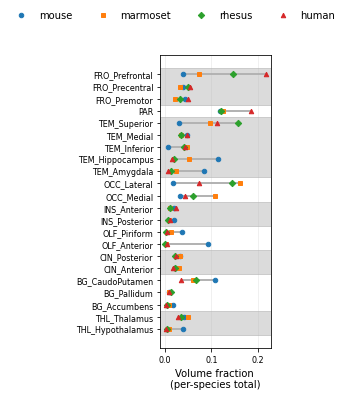

In [3]:


# =========================
# CONFIG
# =========================
species_order = ['mouse', 'marmoset', 'rhesus', 'human']
colors = {'mouse':'#1f77b4','marmoset':'#ff7f0e','rhesus':'#2ca02c','human':'#d62728'}
markers = {'mouse':'o','marmoset':'s','rhesus':'D','human':'^'}

normalize = True
ref_species = 'human'


# =========================
# PREP
# =========================
all_defined = [r for gl in region_groups.values() for r in gl]
regions_available = [r for r in df.index if r in set(all_defined)]
df_use = df.loc[regions_available].copy().astype(float)

if normalize:
    df_use = df_use.div(df_use.sum(axis=0), axis=1)

df_use = df_use[species_order]

# Order regions: by group; inside group surface→deep; then sort by ref species desc
ordered_regions, group_slices = [], []
cursor = 0
for gname, glist in region_groups.items():
    avail = [r for r in glist if r in df_use.index]
    if not avail:
        continue
    g_surface = [r for r in avail if r in surface_regions]
    g_deep    = [r for r in avail if r in deep_regions]
    g_order   = g_surface + g_deep if (g_surface or g_deep) else avail
    ref_vals  = df_use.loc[g_order, ref_species]
    g_sorted  = ref_vals.sort_values(ascending=False).index.tolist()
    start, end = cursor, cursor + len(g_sorted) - 1
    ordered_regions.extend(g_sorted)
    group_slices.append((gname, start, end))
    cursor = end + 1

df_plot = df_use.loc[ordered_regions, :]

# =========================
# PLOT
# =========================
N = len(ordered_regions)
fig_w = 3.0
fig_h = min(6, 0.25 * N)   # <= requested sizing
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

y = np.arange(N)  # 0..N-1 (top row is 0; we invert later so it appears at top)

# Higher-contrast alternating shading by group (no labels)
for i, (_, start, end) in enumerate(group_slices):
    if i % 2 == 0:
        ax.axhspan(start - 0.5, end + 0.5, color='k', alpha=0.14)  

# Dumbbell stems (min→max per region)
mins = df_plot.min(axis=1).values
maxs = df_plot.max(axis=1).values
ax.hlines(y, mins, maxs, color='0.70', linewidth=2, zorder=1)

# Species markers
handles = []
for sp in species_order:
    h = ax.plot(df_plot[sp].values, y, linestyle='None',
                marker=markers.get(sp,'o'), markersize=4.5,
                color=colors.get(sp), label=sp, zorder=2)[0]
    handles.append(h)

# Y axis
ax.set_yticks(y)
ax.set_yticklabels(ordered_regions, fontsize=8)  
ax.invert_yaxis()  

# X axis, grid, labels
ax.grid(axis='x', alpha=0.3, linewidth=0.6)
ax.tick_params(axis='x', labelsize=8)
ax.set_xlabel('Volume fraction \n(per-species total)' if normalize else 'Volume (mm³)')
#ax.set_title(title, fontsize=10.5, pad=6)

# Figure-level legend above the axes (kept clear of first row)
fig.legend(handles, species_order, loc='upper center', ncol=len(species_order),
           frameon=False, bbox_to_anchor=(0.5, 0.995), borderaxespad=0.0)

# Tight layout: leave top room for legend
plt.tight_layout(rect=(0, 0, 1, 0.90))


# Figure 5a-b

#### Flexible string search to identify regions across Neuroparc atlases
atlas source: https://github.com/neurodata/neuroparc

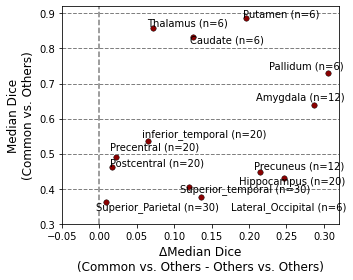

In [4]:
# Set input path to your directory of Dice matrices\
extract_dir = "data\\dice_validation\\"  

dice_files = [f for f in os.listdir(extract_dir) if f.endswith(".csv")]

final_annotated_df = []
boxplot_data = []
for file in dice_files:
    region_name = file.replace(".csv", "").replace("DICE_ROI_", "")   
    df = pd.read_csv(os.path.join(extract_dir, file), index_col=0)    
    # Exclude low-performing atlases
    low_avg_atlases=df.columns[df.median()<.1]        
    df = df.drop(index=low_avg_atlases, columns=low_avg_atlases, errors='ignore')
    if df.shape[0] < 3:
        continue
    common_labels = [idx for idx in df.index if 'Common' in idx]
    if not common_labels:
        continue
    common_label = common_labels[0]

    try:
        common_vs_others = df.loc[common_label].drop(labels=[common_label]).dropna()
        non_common_df = df.drop(index=common_label, columns=common_label)
        inter_comparisons = non_common_df.where(~np.eye(non_common_df.shape[0], dtype=bool)).stack().values

        if len(common_vs_others) < 1 or len(inter_comparisons) < 1:
            continue

        for val in common_vs_others:
            boxplot_data.append({'Region': region_name, 'Type': 'Common vs. Others', 'Dice': val})
        for val in inter_comparisons:
            boxplot_data.append({'Region': region_name, 'Type': 'Others vs. Others', 'Dice': val})
            
        final_annotated_df.append({
            "Region": f"{region_name} (n={len(inter_comparisons)})",
            "Median Dice (Common vs. Others)": common_vs_others.median(),
            "Delta Median (Common vs. Others - Others vs. Others)": common_vs_others.median() - np.median(inter_comparisons)
        })
    except Exception:
        continue

labeled_df = pd.DataFrame(final_annotated_df)

plt.figure(figsize=(5, 4))
ax = sns.scatterplot(
    data=labeled_df,
    x="Delta Median (Common vs. Others - Others vs. Others)",
    y="Median Dice (Common vs. Others)",
    color="darkred",
    s=30,
    edgecolor="black"
)

plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("ΔMedian Dice\n(Common vs. Others - Others vs. Others)", fontsize=12)
plt.ylabel("Median Dice\n(Common vs. Others)", fontsize=12)

texts = []
# Annotate region names with (n)
for _, row in labeled_df.iterrows():
    texts.append(ax.text(
        row["Delta Median (Common vs. Others - Others vs. Others)"],
        row["Median Dice (Common vs. Others)"] + 0.0,
        row["Region"],
        fontsize=10,
        ha='left'
    ))

adjust_text(texts, arrowprops=dict(
    arrowstyle='->',
    color='red',
    linewidth=1,
    linestyle='dotted',
    connectionstyle='angle3,angleA=90,angleB=0',
    alpha=0
))

plt.ylim([.3, .92])
plt.xlim([-.05, .32])

plt.grid(True, axis='y', linestyle='--', linewidth=1, color='gray')
plt.tight_layout()

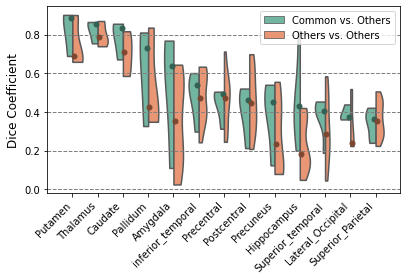

In [5]:
boxplot_df=pd.DataFrame(boxplot_data)

region_order = (
    boxplot_df[boxplot_df['Type'] == 'Common vs. Others']
    .groupby('Region')['Dice']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)


plt.figure(figsize=(5.75, 4))
ax = sns.violinplot(
    data=boxplot_df,
    x='Region', y='Dice', hue='Type',
    order=region_order,
    palette='Set2', split=True, cut=0,
    inner=None  
)

# Get the original colors from palette
palette = sns.color_palette('Set2')
color_map = {
    'Common vs. Others': palette[0],
    'Others vs. Others': palette[1]
}

# Darken each color for marker
def darken_color(color, factor=0.5):
    return tuple([max(0, c * factor) for c in color])

# Add bold median markers with darker hues
for i, region in enumerate(region_order):
    for typ, offset in zip(['Common vs. Others', 'Others vs. Others'], [-0.05, 0.05]):
        subset = boxplot_df[(boxplot_df['Region'] == region) & (boxplot_df['Type'] == typ)]['Dice'].dropna()
        median_val = subset.median()
        marker_color = darken_color(color_map[typ])

        ax.plot(
            i + offset,
            median_val,
            marker='o',
            markersize=5,
            color=marker_color,
            zorder=5
        )

plt.xticks(rotation=45, ha='right')
plt.xlabel("",fontsize=12)
plt.ylabel("Dice Coefficient",fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=1, color='gray')
plt.legend(loc='best', fontsize=10)
plt.tight_layout()

# Figure 5C

In [6]:
chf_rois_primate=['FRO_Precentral', 'FRO_Premotor', 'FRO_Prefrontal', 'PAR_Postcentral', 'PAR_Superior', 'PAR_Inferior', 'PAR_Precuneus',
       'TEM_Superior', 'TEM_Inferior', 'TEM_Medial', 'TEM_Hippocampus', 'TEM_Amygdala', 'OCC_Lateral', 'OCC_Medial', 'INS_Anterior',
       'INS_Posterior', 'OLF_Anterior', 'OLF_Piriform',  'CIN_Anterior', 'CIN_Posterior', 'BG_Caudate', 'BG_Putamen',
       'BG_Accumbens', 'BG_Pallidum', 'THL_Thalamus', 'THL_Hypothalamus']

chf_rois_mouse=['FRO_Precentral', 'FRO_Premotor', 'FRO_Prefrontal',    'PAR',
       'TEM_Superior', 'TEM_Inferior', 'TEM_Medial', 'TEM_Hippocampus',      'TEM_Amygdala', 'OCC_Lateral', 'OCC_Medial', 'INS_Anterior',
       'INS_Posterior', 'OLF_Anterior', 'OLF_Piriform',    'CIN_Anterior', 'CIN_Posterior', 'BG_CaudoPutamen',
       'BG_Accumbens', 'BG_Pallidum',  'THL_Thalamus', 'THL_Hypothalamus']


In [7]:

# --- Load atlas and CHF images ---
atlas_img = nb.load('data/atlases/mouse/ABA_major_regions.nii.gz').get_fdata()
chf_img = nb.load('data/atlases/mouse/cha_mouse.nii.gz').get_fdata()

# --- Load label maps ---
atlas_label_df = pd.read_table('data/atlases/mouse/ABA_major_regions.txt', index_col=0, header=None, delim_whitespace=True)
chf_label_df = pd.read_table('data/atlases/mouse/cha_mouse.txt', index_col=0, header=None, delim_whitespace=True)

# --- Get valid region labels (exclude 0/background) ---
atlas_labels = np.unique(atlas_img)
atlas_labels = atlas_labels[atlas_labels > 0]

chf_labels = np.unique(chf_img)
chf_labels = chf_labels[chf_labels > 0]

# --- Dice similarity function ---
def dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    total = mask1.sum() + mask2.sum()
    return 2 * intersection / total if total > 0 else np.nan

# --- Compute Dice matrix ---
dice_matrix = np.zeros((len(atlas_labels), len(chf_labels)))

for i, atlas_val in enumerate(atlas_labels):
    mask1 = atlas_img == atlas_val
    for j, chf_val in enumerate(chf_labels):
        mask2 = chf_img == chf_val
        dice_matrix[i, j] = dice(mask1, mask2)

# --- Use region names for row/column labels ---
atlas_names = [atlas_label_df.loc[int(val)][1] for val in atlas_labels]
chf_names = [chf_label_df.loc[int(val)][1] for val in chf_labels]

dice_df = pd.DataFrame(dice_matrix, index=[a[:-1] for a in atlas_names], columns=chf_names)




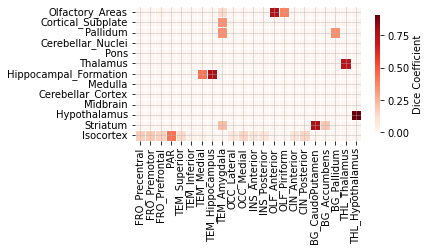

In [8]:


fig=plt.figure(figsize=(6, 6))
sns.heatmap(dice_df[chf_rois_mouse], 
                annot=False, cmap="Reds", fmt=".2f", linewidths=0.5, 
                cbar_kws={'label': 'Dice Coefficient', 
                          'shrink': 0.3,             
                            'aspect': 25,              
                            'ticks': [0.0, 0.25, 0.5, 0.75, 1.0], 
                            'orientation': 'vertical'}, 
                square=True)
plt.grid(alpha=.5)
plt.tight_layout()
plt.show()

# Figure 5d
## Containment validation

In [9]:
from scipy.ndimage import affine_transform

def get_percent_overlap(atlas, tract, roi_indices):
    
    CHF_ROIS=chf_labels_num

    percent_overlap=np.zeros((len(roi_indices), len(CHF_ROIS)))
    print(len(roi_indices))
    for roi_id in range(len(percent_overlap)): 
        if roi_id%100==0:
            print(roi_id)
        for id_ in range(len(percent_overlap[roi_id])):
            percent_overlap[roi_id][id_] =  np.sum(atlas[tract==id_]==roi_indices[roi_id]) /np.sum(atlas==roi_indices[roi_id])
            
    return percent_overlap

#spatial perturbation
def transform_small(atlas_, 
                    chf_nii_, 
                    atlas_labels_, 
                    chf_labels_, 
                    rot=0):
    theta = np.deg2rad(rot)
    affine_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])
    offset = [0, 0, 0]  # voxel shift
    transformed = affine_transform(chf_nii_, affine_matrix, offset=offset, order=0, mode='nearest')

    percent_overlap=get_percent_overlap(atlas_, transformed, atlas_labels_.index.values)
    
    ls_=list(chf_labels_[1].values)
    ls_.insert(0, '0')
    popd_=pd.DataFrame(percent_overlap, index=atlas_labels_[1].values, columns=ls_)
    popd_['SUM']=popd_.sum(axis=1)

    return popd_

### Set species

In [14]:
species='rhesus' #<- change species ['mouse', 'marmoset', 'rhesus']

In [10]:
atlas_dir = 'data\\atlases\\'+species+'\\'        
chf_nii_file= 'cha_'+species+'.nii.gz'

if species=='mouse':    
    atlas_file = 'ABA.nii.gz'    
    chf_rois=chf_rois_mouse
    vols_df=pd.read_table(atlas_dir+'ABA_roistats.txt', index_col=0).loc['volume (mm^3)']
    baseline_overlap_file='ABA_overlaps_L2'
    popd=pd.read_csv(atlas_dir+baseline_overlap_file+'.csv', index_col=0)
    atlasname='ABA'

if species=='marmoset':    
    atlas_file = 'MBM_vH_subcortical.nii.gz'    
    chf_rois=chf_rois_primate
    vols_df=pd.read_table(atlas_dir+'MBM_vH_subcortical_roistats.txt', index_col=0).loc['volume (mm^3)']
    baseline_overlap_file='MBM_vH_subcortical_overlaps_L2b'
    popd=pd.read_csv(atlas_dir+baseline_overlap_file+'.csv', index_col=0)
    atlasname='MBM'
    
if species=='rhesus':    
    atlas_file = 'civm_rhesus_label.nii.gz'    
    chf_rois=chf_rois_primate
    vols_df=pd.read_table(atlas_dir+'civm_rhesus_label_roistats.txt', index_col=0).loc['volume (mm^3)']
    baseline_overlap_file='civm_rhesus_label_overlaps_L2b'
    popd=pd.read_csv(atlas_dir+baseline_overlap_file+'.csv', index_col=0)
    atlasname='CIVM'

nROIs in atlas		 279
nROIs in chf		 31
data\atlases\rhesus\/civm_rhesus_label.nii.gz	 (192, 224, 110)
data\atlases\rhesus\/cha_rhesus.nii.gz	 (192, 224, 110)


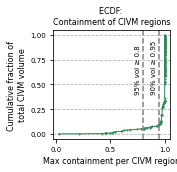

In [11]:
atlas_labels=atlas_file.replace('nii.gz','txt')
atlas_labels=pd.read_table(atlas_dir+atlas_labels, index_col=0, header=None, delim_whitespace=' ')

chf_labels=chf_nii_file.split('.')[0]+'.txt'
chf_labels=pd.read_table(atlas_dir+chf_labels, index_col=0, header=None, delim_whitespace=' ')

at = nb.load(f'{atlas_dir}/{atlas_file}')
chf =nb.load(f'{atlas_dir}/{chf_nii_file}')

atlas = at.get_fdata()
chf_nii=chf.get_fdata()
#Get ROI numerical values for both nii
atlas_labels_num = np.unique(atlas)
chf_labels_num=np.unique(chf_nii)

print('nROIs in atlas\t\t', len(atlas_labels))
print('nROIs in chf\t\t', len(chf_labels))

print(f'{atlas_dir}/{atlas_file}\t', atlas.shape)
print(f'{atlas_dir}/{chf_nii_file}\t', chf_nii.shape)

vols=vols_df.values
# Sort containment scores and get corresponding volumes
containment_values=popd[chf_rois][popd[chf_rois].max(axis=1)>0].max(axis=1)
containment_scores = np.array(containment_values)
volumes = np.array(vols)


sorted_idx = np.argsort(containment_scores)
sorted_scores = containment_scores[sorted_idx]
sorted_volumes = volumes[sorted_idx]

# Compute cumulative sum of volumes
cumulative_volume = np.cumsum(sorted_volumes)
total_volume = np.sum(sorted_volumes)
ecdf_vol_weighted = cumulative_volume / total_volume

# Plot volume-weighted ECDF
plt.figure(figsize=(2.5, 2.5))
plt.plot(sorted_scores, ecdf_vol_weighted, marker='.', markersize=2, linewidth=1, color='seagreen')
plt.xlabel("Max containment per "+atlasname+" region", fontsize=8)
plt.ylabel("Cumulative fraction of \ntotal "+atlasname+" volume", fontsize=8)
plt.title("ECDF: \nContainment of "+atlasname+" regions", fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.xlim([-.025, 1.05])

# Annotate thresholds
for threshold in [0.8, 0.95]:
    prop = np.sum(sorted_volumes[sorted_scores >= threshold]) / total_volume
    plt.axvline(threshold, color='gray', linestyle='--')
    plt.text(threshold - 0.075, 0.4, f"{prop:.0%} vol ≥ {threshold}", rotation=90, va='bottom', fontsize=7)

plt.grid(True, linestyle='--', axis='y', alpha=1)
plt.tight_layout()

#### apply spatial perturbation

#### read spatial perturbation outputs

In [12]:
angles=[0,1,2,3,4,5]
containment_values=[]

for ang in angles:
    popd_=pd.read_csv(atlas_dir+baseline_overlap_file+'_rot'+str(ang)+'.csv', index_col=0)
    containment_values.append(popd_[chf_rois][popd_[chf_rois].max(axis=1)>0].max(axis=1))

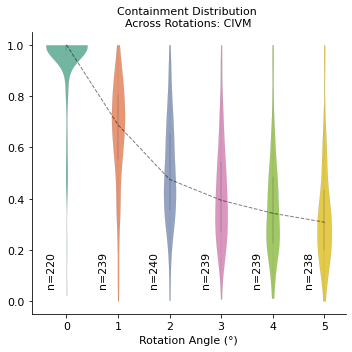

In [13]:
# Flatten into long-form DataFrame
data = pd.DataFrame({
    'Containment': [val for s in containment_values for val in s],
    'Rotation': [angle for angle, s in zip(angles, containment_values) for _ in s]
})

# Compute summary statistics
mean_values = [s.mean() for s in containment_values]
median_values = [s.median() for s in containment_values]

#plt.figure(figsize=(1.35, 1.55))
plt.figure(figsize=(5,5))

ax = sns.violinplot(
    data=data,
    x='Rotation',
    y='Containment',
    palette='Set2',
    cut=0,
    inner='box', linewidth=0.1
)

# Overlay the curve
plt.plot(angles, median_values, '--', color='black', linewidth=1, label='Median Containment', alpha=.5)

region_counts = [len(s) for s in containment_values]
for i, count in enumerate(region_counts):
    ax.text(i-.3, 0.05, f'n={count}', ha='center', va='bottom', fontsize=11, rotation=90)

ax.set_title("Containment Distribution \nAcross Rotations: "+atlasname, fontsize=11)
ax.set_xlabel("Rotation Angle (°)", fontsize=11)
ax.set_ylabel("")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.show()
